In [1]:
import matplotlib.pyplot as plt
import numpy             as np

import gym
import Portfolio_Gym
import DQN_II

In [2]:
# Differences vs previous version:
# Network now contains biases as well as L2 Regluraization
# Environment is multi-step and Bellman Eq. is used to generate update targets


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
100%|██████████| 30000/30000 [06:45<00:00, 73.90it/s]


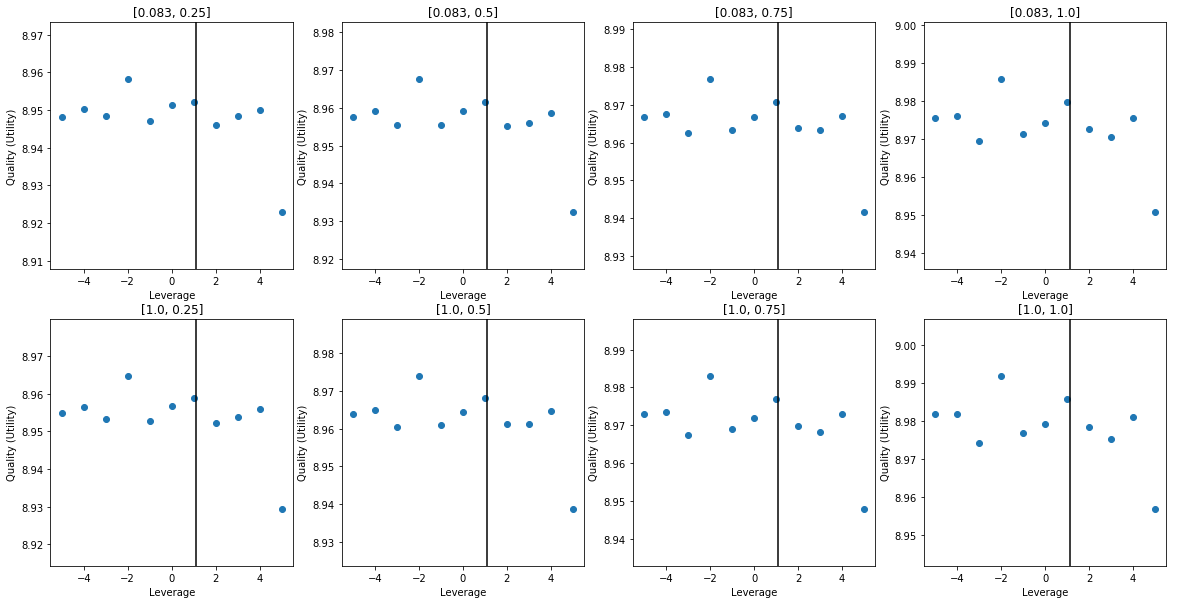

CPU times: user 12min 2s, sys: 1min 6s, total: 13min 8s
Wall time: 6min 47s


In [20]:
%%time

N_Eps  = int(3e4)
Network_Hypers = {"Learning Rate" : 0.01,
                  "Epoch"         : 5,
                  "Network Size"  : [32, 16],
                  "Activation"    : "Sigmoid",
                  "Alpha"         : 0.0,
                  "Batch_Size"    : 0}

Env = gym.make('Simulated-v0')
Env.Set_Params(Mu = 0.05, Sigma = 0.20, Row = 1, Rf = 0.01,
               Max_Leverage  = 5, Min_Leverage  = -5, Time_Horizon  = 1,
               Time_Step     = 1/12, Risk_Aversion = 0.9, Intermediate_Reward = False)


myDQN = DQN_II.DQN(Env, 11, Network_Hypers, Batch_Size = 2048, Retrain_Frequency = 16, 
                  Gamma = 0.9992, Epsilon_Range = [1, 0.1], Epsilon_Anneal = 0.9)

myDQN.Train(N_Eps)

# Plot the results.
# (Time, Wealth)
Plot_State = [[0.083, 0.25], [0.083, 0.50], [0.083, 0.75], [0.083, 1.00],
              [1.0,  0.25], [1.0,  0.50], [1.0,  0.75], [1.0,  1.00]]

f, ax = plt.subplots(2,4, figsize = (20,10))
for i in range(2):
    for j in range(4):
        k = i * 4 + j
        ax[i, j].set_title(str(Plot_State[k])) 
        ax[i, j].set_xlabel("Leverage")
        ax[i, j].set_ylabel("Quality (Utility)")
        ax[i, j].scatter(np.linspace(5, -5, 11), myDQN.Predict_Q(np.array(Plot_State[k]).reshape(1,2)))    
        ax[i, j].axvline((Env.Mu - Env.Rf) / (Env.Risk_Aversion * (Env.Sigma ** 2)), color = 'k')

plt.show()


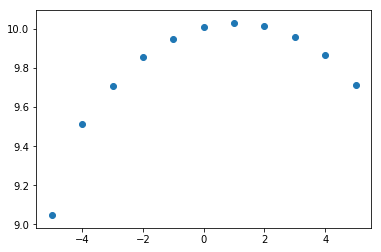

In [17]:
# Determine the actual solution so we may assess the DQN's performance.
def Run_Episode(Action):
    Env.Set_Params(Mu = 0.05, Sigma = 0.20, Row = 1, Rf = 0.01,
               Max_Leverage  = 5, Min_Leverage  = -5, Time_Horizon  = 1,
               Time_Step     = 1/12, Risk_Aversion = 0.9, Intermediate_Reward = False)
    
    S = Env.reset()
    Env.Wealth = 1
    D = False
    
    while D == False:
        S, R, D, I = Env.step(np.array([Action]))
    
    return R

Results = np.zeros(11)

for i, action in enumerate(np.linspace(-5, 5, 11)):
    for _ in range(10000):
        Results[i] += Run_Episode(action)
    Results[i] = Results[i] / 10000
    
plt.scatter(np.linspace(-5,5,11), Results)
